In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve,
                             average_precision_score)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler

Creating and training model...
Evaluating model...
Model Accuracy: 1.0000
Model AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52922
           1       1.00      1.00      1.00     63970

    accuracy                           1.00    116892
   macro avg       1.00      1.00      1.00    116892
weighted avg       1.00      1.00      1.00    116892



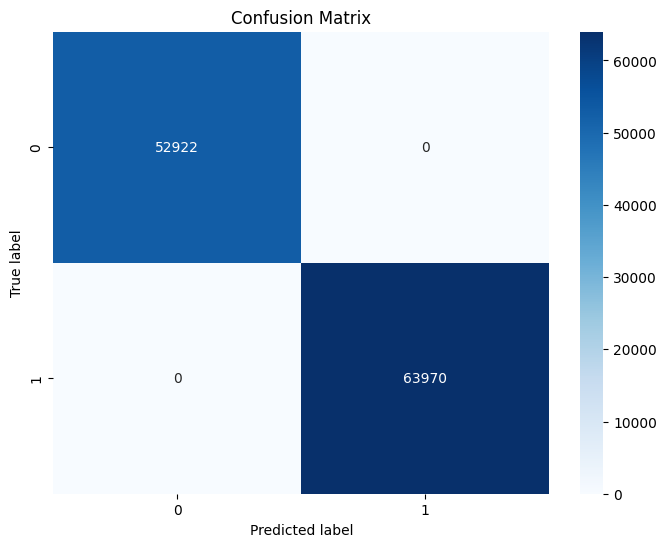

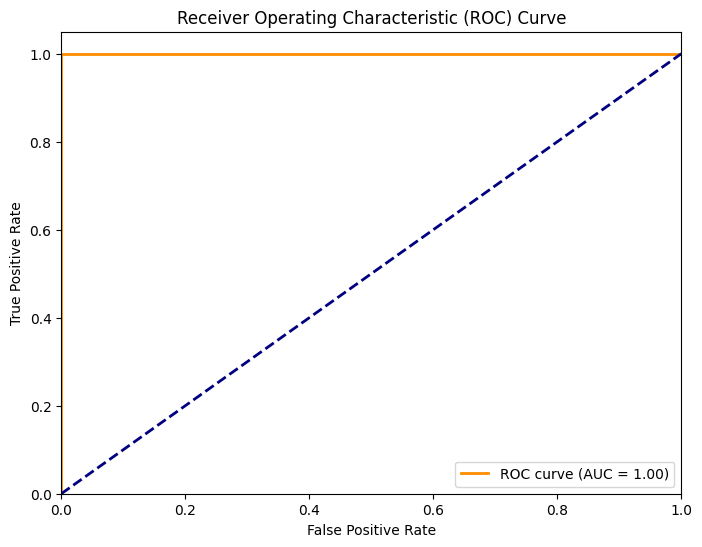

Creating submission file...
Submission file created successfully at submission_final_rf.csv


In [2]:
class RatingClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns, min_val=0, max_val=5):
        self.columns = columns
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.clip(X_copy[col], self.min_val, self.max_val)
        return X_copy

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            Q1 = X_copy[col].quantile(0.25)
            Q3 = X_copy[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X_copy[col] = np.clip(X_copy[col], lower_bound, upper_bound)
        return X_copy

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Feature Engineering
        service_columns = ['Inflight entertainment', 'Ease of Online booking', 'Online support', 
                           'On-board service', 'Online boarding', 'Leg room service', 
                           'Checkin service', 'Baggage handling', 'Cleanliness']
        X_transformed['Service Score'] = X_transformed[service_columns].mean(axis=1)
        
        X_transformed['Is_Loyal'] = (X_transformed['Customer Type'] == 'Loyal Customer').astype(int)
        X_transformed['Is_Business_Class'] = (X_transformed['Class'] == 'Business').astype(int)
        X_transformed['Is_Business_Travel'] = (X_transformed['Type of Travel'] == 'Business travel').astype(int)

        # Age groups
        X_transformed['Age_Group'] = pd.cut(X_transformed['Age'], 
                                            bins=[0, 18, 30, 40, 50, 60, 70, 80, 100], 
                                            labels=['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+'])

        # Delay categories
        X_transformed['Delay_Category'] = pd.cut(X_transformed['Arrival Delay in Minutes'], 
                                                 bins=[-np.inf, 0, 30, 60, np.inf], 
                                                 labels=['No Delay', 'Short Delay', 'Medium Delay', 'Long Delay'])

        # Total Delay
        X_transformed['Total Delay'] = X_transformed['Departure Delay in Minutes'] + X_transformed['Arrival Delay in Minutes']

        return X_transformed

def create_pipeline():
    rating_features = ['Inflight entertainment', 'Ease of Online booking', 'Online support', 
                       'On-board service', 'Leg room service', 'Checkin service', 
                       'Cleanliness', 'Seat comfort', 'Food and drink', 'Gate location',
                       'Inflight wifi service', 'Baggage handling', 'Online boarding']
    
    delay_features = ['Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Total Delay']
    other_numeric_features = ['Age', 'Flight Distance', 'Service Score']
    categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 
                            'Age_Group', 'Delay_Category', 'Is_Loyal', 'Is_Business_Class', 'Is_Business_Travel']

    rating_transformer = Pipeline(steps=[
        ('clipper', RatingClipper(columns=rating_features)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    delay_transformer = Pipeline(steps=[
        ('outlier', OutlierHandler(columns=delay_features)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    other_numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('ratings', rating_transformer, rating_features),
            ('delays', delay_transformer, delay_features),
            ('other_numeric', other_numeric_transformer, other_numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    pipeline = Pipeline([
        ('engineer', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    criterion='gini',        # Function to measure the quality of a split
    max_depth=None,          # Maximum depth of the tree
    min_samples_split=2,     # Minimum number of samples required to split an internal node
    min_samples_leaf=1,      # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the input samples required to be at a leaf node
    max_leaf_nodes=None,     # Maximum number of leaf nodes
    min_impurity_decrease=0.0,     # Threshold for early stopping in tree growth
    bootstrap=True,          # Whether bootstrap samples are used when building trees
    oob_score=False,         # Whether to use out-of-bag samples to estimate the generalization accuracy
    n_jobs=None,             # Number of jobs to run in parallel
    random_state=None,       # Controls randomness of the estimator
    verbose=0,               # Controls verbosity
    warm_start=False,        # Reuse the solution of the previous call to fit
    class_weight=None        # Weights associated with classes
))
    ])
    
    return pipeline

def load_and_preprocess_data(train_path, test_path):
    # Load data
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # Encode target variable
    le = LabelEncoder()
    train['satisfaction'] = le.fit_transform(train['satisfaction'])
    
    # Split features and target
    X = train.drop(columns=['satisfaction', 'Id'])
    y = train['satisfaction']
    
    return X, y, test

def evaluate_model(model, X, y):
    # Make predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    
    # Print results
    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Model AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def create_submission(model, test, submission_path):
    # Make predictions
    test_predictions = model.predict(test.drop(columns=['Id']))
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'ID': test['Id'],
        'satisfaction': pd.Series(test_predictions).map({0: 'dissatisfied', 1: 'satisfied'})
    })
    
    # Save submission
    submission.to_csv(submission_path, index=False)
    print(f"Submission file created successfully at {submission_path}")

def main():
    # Load and preprocess data
    train_path = '/kaggle/input/fly-high-with-fds/train.csv'  
    test_path = '/kaggle/input/fly-high-with-fds/test.csv'    
    X, y, test = load_and_preprocess_data(train_path, test_path)
    
    # Create and train model
    print("Creating and training model...")
    model = create_pipeline()
    model.fit(X, y)
    
    # Evaluate model
    print("Evaluating model...")
    evaluate_model(model, X, y)
    
    # Create submission
    print("Creating submission file...")
    create_submission(model, test, 'submission_final_rf.csv')

if __name__ == "__main__":
    main()

In [3]:
# class FeatureEngineer(BaseEstimator, TransformerMixin):
#     def __init__(self, n_neighbors=5):
#         self.numeric_imputer = KNNImputer(n_neighbors=n_neighbors)
#         self.categorical_imputer = SimpleImputer(strategy='most_frequent')

#     def fit(self, X, y=None):
#         # Fit imputers and calculate thresholds
#         numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
#         categorical_columns = X.select_dtypes(include=['object']).columns
#         self.numeric_imputer.fit(X[numeric_columns])
#         self.categorical_imputer.fit(X[categorical_columns])
#         return self

#     def transform(self, X):
#         X_transformed = X.copy()

#         # Apply imputation
#         numeric_columns = X_transformed.select_dtypes(include=['int64', 'float64']).columns
#         categorical_columns = X_transformed.select_dtypes(include=['object']).columns
#         X_transformed[numeric_columns] = self.numeric_imputer.transform(X_transformed[numeric_columns])
#         X_transformed[categorical_columns] = self.categorical_imputer.transform(X_transformed[categorical_columns])

#         # Step: Outlier Detection using IQR and cap outliers
#         for col in ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes','On-board service','Checkin service']:
#             Q1 = X_transformed[col].quantile(0.25)
#             Q3 = X_transformed[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR
#             X_transformed[col] = np.clip(X_transformed[col], lower_bound, upper_bound)  # Cap the outliers

#         # Calculate service-related features
#         service_columns = ['Inflight wifi service', 'Inflight entertainment', 'Online support', 
#                            'On-board service', 'Leg room service', 'Baggage handling', 
#                            'Checkin service', 'Cleanliness']
#         X_transformed['Service Score'] = X_transformed[service_columns].mean(axis=1)
#         X_transformed['Service Variance'] = X_transformed[service_columns].var(axis=1)

#         # Feature Engineering
#         X_transformed['Is_Loyal'] = (X_transformed['Customer Type'] == 'Loyal Customer').astype(int)
#         X_transformed['Is_Business_Class'] = (X_transformed['Class'] == 'Business').astype(int)
#         X_transformed['Is_Business_Travel'] = (X_transformed['Type of Travel'] == 'Business travel').astype(int)
#         X_transformed['Is_Female'] = (X_transformed['Gender'] == 'Female').astype(int)

#         # Age groups
#         X_transformed['Age_Group'] = pd.cut(X_transformed['Age'], 
#                                             bins=[0, 18, 30, 40, 50, 60, 70, 80, 100], 
#                                             labels=['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+'])

#         # Delay categories
#         X_transformed['Delay_Category'] = pd.cut(X_transformed['Arrival Delay in Minutes'], 
#                                                  bins=[-np.inf, 0, 30, 60, np.inf], 
#                                                  labels=['No Delay', 'Short Delay', 'Medium Delay', 'Long Delay'])

#         return X_transformed

# def create_robust_pipeline():
#     # Define feature groups
#     rating_features = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink',
#                        'Gate location', 'Inflight wifi service', 'Inflight entertainment',
#                        'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service',
#                        'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
    
#     large_value_features = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
#     other_numeric_features = ['Age']
#     categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 
#                             'Age Group', 'Distance Category']
    
#     # Define transformers
#     rating_transformer = Pipeline(steps=[
#         ('imputer', KNNImputer(n_neighbors=5))  # Only impute ratings, no scaling
#     ])
    
#     large_value_transformer = Pipeline(steps=[
#         ('imputer', KNNImputer(n_neighbors=5)),
#         ('scaler', RobustScaler())  # Scale large values with outliers
#     ])
    
#     other_numeric_transformer = Pipeline(steps=[
#         ('imputer', KNNImputer(n_neighbors=5)),
#         ('scaler', RobustScaler())  # General scaling for other numeric features
#     ])
    
#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),  # Most frequent strategy for categorical features
#         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
#     ])
    
#     # Combine transformers
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('ratings', rating_transformer, rating_features),
#             ('large_values', large_value_transformer, large_value_features),
#             ('other_numeric', other_numeric_transformer, other_numeric_features),
#             ('cat', categorical_transformer, categorical_features)
#         ])
    
#     # Create full pipeline
#     pipeline = Pipeline([
#         ('engineer', FeatureEngineer()),
#         ('preprocessor', preprocessor)
#     ])
    
#     return pipeline

# def objective_xgb(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#         'random_state': 42,
#         'use_label_encoder': False,
#         'eval_metric': 'logloss'
#     }
    
#     model = XGBClassifier(**param)
#     model.fit(X_train_smote, y_train_smote)
#     auc = roc_auc_score(y_val, model.predict_proba(X_val_preprocessed)[:, 1])
#     return auc

# def objective_catboost(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val):
#     param = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'depth': trial.suggest_int('depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'random_state': 42,
#     }
    
#     model = CatBoostClassifier(**param, verbose=0)
#     model.fit(X_train_smote, y_train_smote)
#     auc = roc_auc_score(y_val, model.predict_proba(X_val_preprocessed)[:, 1])
#     return auc

# def objective_gb(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'random_state': 42
#     }
    
#     model = GradientBoostingClassifier(**param)
#     model.fit(X_train_smote, y_train_smote)
#     auc = roc_auc_score(y_val, model.predict_proba(X_val_preprocessed)[:, 1])
#     return auc

# def optimize_models(X_train_smote, y_train_smote, X_val_preprocessed, y_val):
#     # Optimize XGBoost
#     study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
#     study_xgb.optimize(lambda trial: objective_xgb(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val), n_trials=2)
    
#     # Optimize CatBoost
#     study_catboost = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
#     study_catboost.optimize(lambda trial: objective_catboost(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val), n_trials=2)
    
#     # Optimize GradientBoosting
#     study_gb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
#     study_gb.optimize(lambda trial: objective_gb(trial, X_train_smote, y_train_smote, X_val_preprocessed, y_val), n_trials=2)
    
#     return study_xgb.best_params, study_catboost.best_params, study_gb.best_params

# def load_and_preprocess_data(train_path, test_path):
#     # Load data
#     train = pd.read_csv(train_path)
#     test = pd.read_csv(test_path)
    
#     # Encode target variable
#     le = LabelEncoder()
#     train['satisfaction'] = le.fit_transform(train['satisfaction'].astype(str))
    
#     # Split features and target
#     X = train.drop(columns=['satisfaction', 'Id'])
#     y = train['satisfaction']
    
#     # Split data
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
#     # Create and apply preprocessing pipeline
#     pipeline = create_robust_pipeline()
#     X_train_preprocessed = pipeline.fit_transform(X_train)
#     X_val_preprocessed = pipeline.transform(X_val)
    
#     # Apply SMOTE to handle class imbalance
#     smote = SMOTE(random_state=42)
#     X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
    
#     return X_train_smote, y_train_smote, X_val_preprocessed, y_val, pipeline, test

# def create_stacked_model(best_params_xgb, best_params_catboost, best_params_gb):
#     # Create base models with optimized parameters
#     xgb_model = XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')
#     catboost_model = CatBoostClassifier(**best_params_catboost, verbose=0)
#     gb_model = GradientBoostingClassifier(**best_params_gb)
    
#     # Create stacked model
#     stacked_model = StackingClassifier(
#         estimators=[
#             ('xgb', xgb_model),
#             ('catboost', catboost_model),
#             ('gb', gb_model)
#         ],
#         final_estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
#         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#         n_jobs=-1
#     )
    
#     return stacked_model

# def evaluate_model(model, X_val_preprocessed, y_val):
#     # Make predictions
#     y_val_pred = model.predict(X_val_preprocessed)
#     y_val_pred_proba = model.predict_proba(X_val_preprocessed)[:, 1]
    
#     # Calculate metrics
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     val_auc = roc_auc_score(y_val, y_val_pred_proba)
    
#     # Print results
#     print(f"Model Validation Accuracy: {val_accuracy:.4f}")
#     print(f"Model Validation AUC: {val_auc:.4f}")
#     print("Model Classification Report:")
#     print(classification_report(y_val, y_val_pred))
    
#     # 1. Confusion Matrix
#     cm = confusion_matrix(y_val, y_val_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title('Confusion Matrix')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()
    
#     # 2. ROC Curve
#     fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {val_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.show()
    
#     # 3. Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
#     average_precision = average_precision_score(y_val, y_val_pred_proba)
#     plt.figure(figsize=(8, 6))
#     plt.step(recall, precision, color='b', alpha=0.2, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
#     plt.show()
    
#     # 4. Calibration Curve
#     prob_true, prob_pred = calibration_curve(y_val, y_val_pred_proba, n_bins=10)
#     plt.figure(figsize=(8, 6))
#     plt.plot(prob_pred, prob_true, marker='o')
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.xlabel('Mean predicted probability')
#     plt.ylabel('Fraction of positives')
#     plt.title('Calibration Curve')
#     plt.show()
    
#     # 5. Feature Importance (for XGBoost model)
#     if hasattr(model, 'feature_importances_'):
#         feature_importance = model.feature_importances_
#         feature_names = X_val_preprocessed.columns
#         sorted_idx = np.argsort(feature_importance)
#         pos = np.arange(sorted_idx.shape[0]) + .5
        
#         plt.figure(figsize=(10, 12))
#         plt.barh(pos, feature_importance[sorted_idx], align='center')
#         plt.yticks(pos, np.array(feature_names)[sorted_idx])
#         plt.xlabel('Feature Importance')
#         plt.title('Feature Importance (XGBoost)')
#         plt.tight_layout()
#         plt.show()

# def create_submission(model, pipeline, test, submission_path):
#     # Preprocess test data
#     test_preprocessed = pipeline.transform(test.drop(columns=['Id']))
    
#     # Make predictions
#     test_predictions = model.predict(test_preprocessed)
    
#     # Create submission dataframe
#     submission = pd.DataFrame({
#         'ID': test['Id'],
#         'satisfaction': pd.Series(test_predictions).map({0: 'dissatisfied', 1: 'satisfied'})
#     })
    
#     # Save submission
#     submission.to_csv(submission_path, index=False)
#     print(f"Submission file created successfully at {submission_path}")

# def main():
#     # Load and preprocess data
#     train_path = '/kaggle/input/fly-high-with-fds/train.csv'  
#     test_path = '/kaggle/input/fly-high-with-fds/test.csv'    
#     X_train_smote, y_train_smote, X_val_preprocessed, y_val, pipeline, test = load_and_preprocess_data(train_path, test_path)
    
#     # Optimize models
#     print("Optimizing models...")
#     best_params_xgb, best_params_catboost, best_params_gb = optimize_models(X_train_smote, y_train_smote, X_val_preprocessed, y_val)
    
#     # Create and train stacked model
#     print("Creating and training stacked model...")
#     stacked_model = create_stacked_model(best_params_xgb, best_params_catboost, best_params_gb)
#     stacked_model.fit(X_train_smote, y_train_smote)
    
#     # Evaluate model
#     print("Evaluating model...")
#     evaluate_model(stacked_model, X_val_preprocessed, y_val)
    
#     # Create submission
#     print("Creating submission file...")
#     create_submission(stacked_model, pipeline, test, 'submission.csv')

# if __name__ == "__main__":
#     main()